<a href="https://colab.research.google.com/github/zwubbena/sample-size-tables/blob/main/sample_size_moe_thresholds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

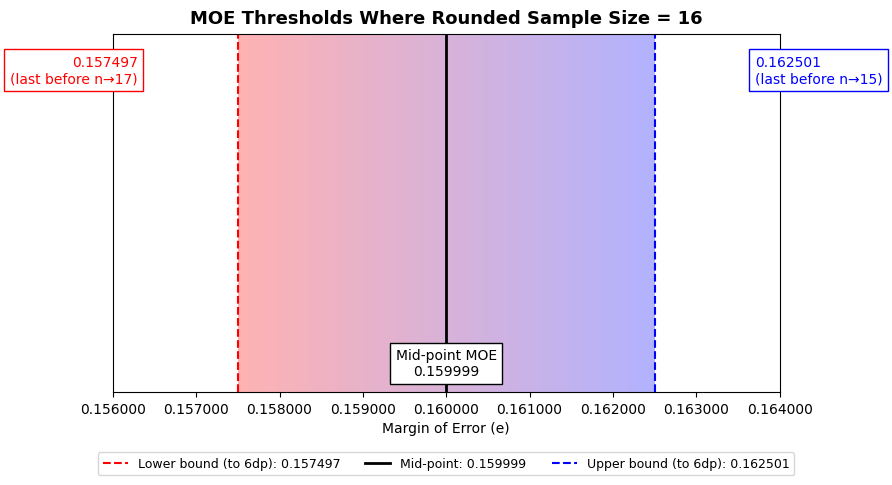

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
# ==========================================================
# Sample Size MOE Thresholds = 16 (Colab Ready)
# - Computes the MOE interval where rounded n == 16 (Cochran + FPC)
# - Shows lower bound, midpoint, upper bound
# - Uses "last 6-digit value before change" for display
# - Inline plot + auto-export PDF
# ==========================================================

import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.ticker import FormatStrFormatter
from google.colab import files

# -------------------------------
# Parameters (edit if needed)
# -------------------------------
CL = 0.80
Z  = 1.28
p  = 0.50
N  = 20000
n_target = 16         # we’re targeting sample size 16
search_min = 0.12     # MOE search band (reasonable window)
search_max = 0.20

pdf_name = "MOE_Thresholds_for_n16.pdf"

# -------------------------------
# Core math
# -------------------------------
def n0_infinite(Z, p, e):
    return (Z**2 * p * (1 - p)) / (e**2)

def n_fpc(N, Z, p, e):
    n0 = n0_infinite(Z, p, e)
    return n0 / (1 + (n0 - 1) / N)

def round_half_up(x):
    return int(math.floor(x + 0.5))

# f(e) = rounded_n(e) - n_target
def f(e):
    return round_half_up(n_fpc(N, Z, p, e)) - n_target

# -------------------------------
# Find the e-interval where rounded n == n_target
# -------------------------------
def find_interval_for_n(n_target, e_lo, e_hi, steps=20000):
    """Coarse scan to find contiguous [a, b] where f(e) == 0."""
    es = np.linspace(e_lo, e_hi, steps)
    vals = np.array([f(e) for e in es])

    inside = (vals == 0)
    if not inside.any():
        return None, None

    idx = np.where(inside)[0]
    a = es[idx[0]]
    b = es[idx[-1]]
    return a, b

def refine_boundary(target_state, e_left, e_right, tol=1e-10, max_iter=80):
    """
    Refine boundary by binary search so that:
      - if target_state==0, we find an interior point where f(e)==0
      - otherwise we find the boundary where f changes value
    This helper expects e_left and e_right straddle a boundary.
    """
    fl = f(e_left)
    fr = f(e_right)
    for _ in range(max_iter):
        mid = (e_left + e_right) / 2
        fm  = f(mid)
        if target_state == 0:
            # drive to inside region
            if fm == 0:
                e_right = mid
                fr = fm
            else:
                e_left = mid
                fl = fm
        else:
            # drive to change point
            if fm == fr:
                e_right = mid
                fr = fm
            else:
                e_left  = mid
                fl = fm
        if abs(e_right - e_left) < tol:
            break
    return (e_left + e_right) / 2

def refine_interval(a0, b0, pad=5e-3, tol=1e-12):
    """
    Given a coarse interval [a0, b0] where f==0,
    push slightly outward, then refine left/right boundaries.
    """
    L = max(search_min, a0 - pad)
    R = min(search_max, b0 + pad)

    # Refine left boundary: find where it switches from !0 to 0
    # Scan leftwards a bit to ensure sign change
    l1, l2 = L, a0
    # Ensure f(l1) != 0 and f(l2) == 0 (if not, nudge)
    if f(l2) != 0:
        l2 = refine_boundary(0, l1, l2, tol=tol)
    left = refine_boundary(1, l1, l2, tol=tol)  # boundary point

    # Refine right boundary: find where it switches from 0 to !0
    r1, r2 = b0, R
    # Ensure f(r1) == 0 and f(r2) != 0 (if not, nudge)
    if f(r1) != 0:
        r1 = refine_boundary(0, r1, r2, tol=tol)
    right = refine_boundary(1, r1, r2, tol=tol)  # boundary point

    return left, right

# 1) Coarse interval
a_coarse, b_coarse = find_interval_for_n(n_target, search_min, search_max, steps=40001)
if a_coarse is None:
    raise RuntimeError("Could not find any MOE interval where rounded n equals 16. Adjust search_min/search_max.")

# 2) Refine to precise real-number bounds (true math bounds)
e_low_true, e_high_true = refine_interval(a_coarse, b_coarse)

# 3) Midpoint (for the “mid-point MOE” line)
e_mid = (e_low_true + e_high_true) / 2

# 4) Display bounds: “last 6-digit value before change”
#    - For the lower bound: smallest MOE that still yields n=16, to 6 decimals → ceil at 1e6
#    - For the upper bound: largest MOE that still yields n=16, to 6 decimals → floor at 1e6
e_low_display  = math.ceil(e_low_true  * 1_000_000) / 1_000_000
e_high_display = math.floor(e_high_true * 1_000_000) / 1_000_000

# Safety clamp to ensure they still map to n_target after rounding rules
if f(e_low_display) != 0:
    # step upward until it does or give up after a few micro-steps
    for _ in range(20):
        e_low_display += 1e-6
        if f(e_low_display) == 0:
            break

if f(e_high_display) != 0:
    for _ in range(20):
        e_high_display -= 1e-6
        if f(e_high_display) == 0:
            break

# -------------------------------
# Plot helper: gradient fill
# -------------------------------
def add_horizontal_gradient(ax, x0, x1, alpha=0.30, n=300):
    y0, y1 = ax.get_ylim()
    xs = np.linspace(x0, x1, n + 1)
    quads, colors = [], []
    for i in range(n):
        quads.append([(xs[i], y0), (xs[i+1], y0), (xs[i+1], y1), (xs[i], y1)])
        t = i / (n - 1) if n > 1 else 0.0
        colors.append((1.0 - t, 0.0, t, alpha))  # red -> blue
    pc = PolyCollection(quads, facecolors=colors, edgecolors='none', zorder=0.5)
    ax.add_collection(pc)

# -------------------------------
# Build visualization
# -------------------------------
fig, ax = plt.subplots(figsize=(9, 5))

# X-limits with a little padding around the true bounds
pad = 0.0015
ax.set_xlim(e_low_true - pad, e_high_true + pad)
ax.set_ylim(0, 1)  # simple strip chart

# Gradient between true bounds
add_horizontal_gradient(ax, e_low_true, e_high_true, alpha=0.30)

# Vertical decision lines
ax.axvline(e_low_display,  color='red',  linestyle='--', linewidth=1.5, label=f"Lower bound (to 6dp): {e_low_display:.6f}")
ax.axvline(e_mid,          color='black', linestyle='-',  linewidth=2.0,  label=f"Mid-point: {e_mid:.6f}")
ax.axvline(e_high_display, color='blue', linestyle='--',  linewidth=1.5, label=f"Upper bound (to 6dp): {e_high_display:.6f}")

# Labels, nudged away from lines
ax.text(e_low_display  - (pad*0.8), 0.90, f"{e_low_display:.6f}\n(last before n→17)",  color='red',
        ha='right', va='center', bbox=dict(facecolor='white', edgecolor='red'))
ax.text(e_high_display + (pad*0.8), 0.90, f"{e_high_display:.6f}\n(last before n→15)", color='blue',
        ha='left', va='center', bbox=dict(facecolor='white', edgecolor='blue'))
ax.text(e_mid, 0.08, f"Mid-point MOE\n{e_mid:.6f}", color='black',
        ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black'))

# Cosmetics
ax.set_title("MOE Thresholds Where Rounded Sample Size = 16", fontsize=13, fontweight='bold', pad=8)
ax.set_xlabel("Margin of Error (e)")
ax.get_yaxis().set_visible(False)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=9)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.6f'))

plt.tight_layout()
plt.show()

# -------------------------------
# Export PDF and auto-download
# -------------------------------
fig.savefig(pdf_name, bbox_inches='tight', dpi=300)
files.download(pdf_name)


# V2

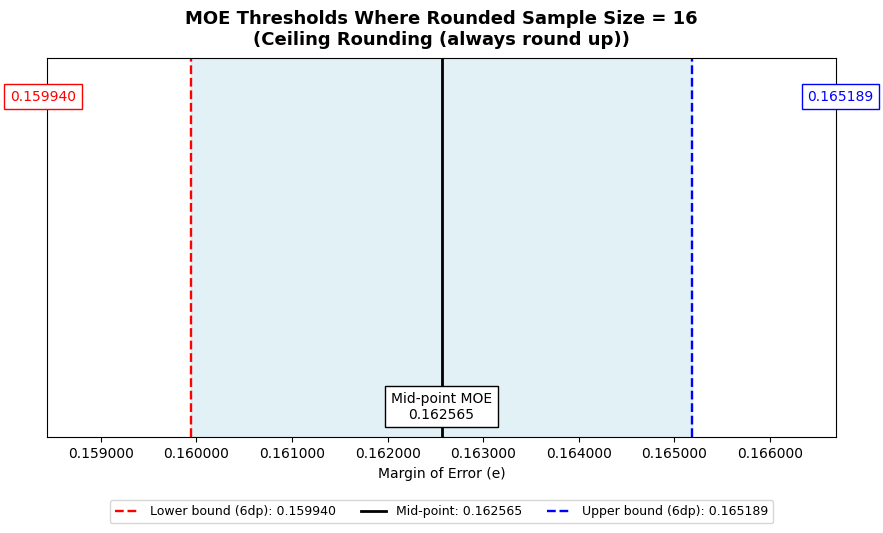

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
# ==============================================
# MOE Thresholds for n = 16 (Two-Page PDF)
# Page 1: Ceiling rounding
# Page 2: Round-half-up rounding
# - Light blue shading between lower and upper MOE bounds
# - Inline display (Page 1) + auto-export PDF
# ==============================================

import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import FormatStrFormatter
from google.colab import files

# --------- Parameters (edit if needed) ---------
# These match your project defaults
CL = 0.80
Z  = 1.28
p  = 0.50
N  = 20000
TARGET_N = 16

# Reasonable search window for e around ~0.16
E_MIN_SEARCH = 0.10
E_MAX_SEARCH = 0.25

PDF_NAME = "MOE_Thresholds_n16_Ceiling_vs_RoundHalfUp.pdf"
# -----------------------------------------------

# --------- Cochran + FPC ---------
def n_fpc(N, Z, p, e):
    n0 = (Z**2 * p * (1 - p)) / (e**2)
    return n0 / (1 + (n0 - 1) / N)

def round_half_up(x):
    return int(math.floor(x + 0.5))

def apply_rounding(n, method):
    if method == "ceiling":
        return math.ceil(n)
    elif method == "round":
        return round_half_up(n)
    else:
        raise ValueError("method must be 'ceiling' or 'round'")

# f_method(e) = rounded(n(e)) - TARGET_N
def f_method(e, method):
    return apply_rounding(n_fpc(N, Z, p, e), method) - TARGET_N

# --------- Find interval where rounded n == TARGET_N ---------
def find_coarse_interval(method, e_lo, e_hi, steps=40001):
    es = np.linspace(e_lo, e_hi, steps)
    vals = np.array([f_method(e, method) for e in es])
    inside = (vals == 0)
    if not inside.any():
        return None, None
    idx = np.where(inside)[0]
    return es[idx[0]], es[idx[-1]]

def refine_boundary_to_change(method, left, right, tol=1e-12, max_iter=80):
    """Binary search to boundary where f changes value (from ==0 to !=0 or vice versa)."""
    fL = f_method(left, method)
    fR = f_method(right, method)
    for _ in range(max_iter):
        mid = (left + right) / 2
        fM  = f_method(mid, method)
        # We want the point right at the change; push toward the boundary
        if fM == fR:
            right = mid
            fR = fM
        else:
            left = mid
            fL = fM
        if abs(right - left) < tol:
            break
    return (left + right) / 2

def refine_interval(method, a0, b0, pad=5e-4):
    """Expand slightly then refine left and right boundaries precisely."""
    L = max(E_MIN_SEARCH, a0 - pad)
    R = min(E_MAX_SEARCH, b0 + pad)

    # Left boundary: from outside (!=0) into inside (==0)
    if f_method(a0, method) != 0:
        # nudge inward
        a0 = refine_boundary_to_change(method, L, a0)
    left = refine_boundary_to_change(method, L, a0)

    # Right boundary: from inside (==0) out to (!=0)
    if f_method(b0, method) != 0:
        b0 = refine_boundary_to_change(method, b0, R)
    right = refine_boundary_to_change(method, b0, R)

    return left, right

def get_bounds(method):
    # 1) coarse locate
    a, b = find_coarse_interval(method, E_MIN_SEARCH, E_MAX_SEARCH, steps=50001)
    if a is None:
        raise RuntimeError(f"Could not find any MOE interval where {method} rounding gives n={TARGET_N}. "
                           f"Try widening E_MIN_SEARCH/E_MAX_SEARCH.")
    # 2) refine
    e_low_true, e_high_true = refine_interval(method, a, b)
    # 3) midpoint
    e_mid = (e_low_true + e_high_true) / 2
    # 4) display values to 6 decimals
    e_low_disp  = math.ceil(e_low_true  * 1_000_000) / 1_000_000   # smallest 6dp still inside
    e_high_disp = math.floor(e_high_true * 1_000_000) / 1_000_000  # largest 6dp still inside
    # small safety adjustments if rounding mismatch sneaks in
    if f_method(e_low_disp, method) != 0:
        for _ in range(30):
            e_low_disp += 1e-6
            if f_method(e_low_disp, method) == 0:
                break
    if f_method(e_high_disp, method) != 0:
        for _ in range(30):
            e_high_disp -= 1e-6
            if f_method(e_high_disp, method) == 0:
                break
    return e_low_true, e_mid, e_high_true, e_low_disp, e_high_disp

# --------- Draw a single page ---------
def draw_page(method_label, method_key, pdf, show_inline=False):
    eL_true, eMid, eH_true, eL, eH = get_bounds(method_key)

    fig, ax = plt.subplots(figsize=(9, 5.5))

    # X-limits with padding so labels don't clip
    pad = 0.0015
    ax.set_xlim(eL_true - pad, eH_true + pad)
    ax.set_ylim(0, 1)

    # Light blue shading between true bounds
    ax.axvspan(eL_true, eH_true, color='lightblue', alpha=0.35, zorder=0.5)

    # Vertical lines
    ax.axvline(eL,  color='red',  linestyle='--', linewidth=1.7, label=f"Lower bound (6dp): {eL:.6f}")
    ax.axvline(eMid, color='black', linestyle='-',  linewidth=2.0, label=f"Mid-point: {eMid:.6f}")
    ax.axvline(eH,  color='blue', linestyle='--',  linewidth=1.7, label=f"Upper bound (6dp): {eH:.6f}")

    # Labels (nudged away from lines)
    ax.text(eL - pad*0.8, 0.90, f"{eL:.6f}", color='red',
            ha='right', va='center', bbox=dict(facecolor='white', edgecolor='red'))
    ax.text(eH + pad*0.8, 0.90, f"{eH:.6f}", color='blue',
            ha='left', va='center', bbox=dict(facecolor='white', edgecolor='blue'))
    ax.text(eMid, 0.08, f"Mid-point MOE\n{eMid:.6f}", color='black',
            ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black'))

    # Title and axes
    ax.set_title(f"MOE Thresholds Where Rounded Sample Size = {TARGET_N}\n({method_label})",
                 fontsize=13, fontweight='bold', pad=10)
    ax.set_xlabel("Margin of Error (e)")
    ax.get_yaxis().set_visible(False)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.6f'))

    # Legend below the x-axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=9)

    plt.tight_layout()
    if show_inline:
        plt.show()
    pdf.savefig(fig)
    plt.close(fig)

# ----------------- Build PDF -----------------
with PdfPages(PDF_NAME) as pdf:
    # Page 1 — Ceiling rounding
    draw_page("Ceiling Rounding (always round up)", "ceiling", pdf, show_inline=True)
    # Page 2 — Round-half-up rounding
    draw_page("Round-Half-Up Rounding (.5 rounds up)", "round", pdf, show_inline=False)

# Auto-download
files.download(PDF_NAME)
